In [2]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


## Generating data from REINVENT, CReM, SAFE, and COATI

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


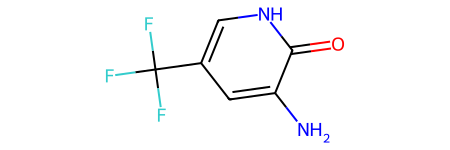

In [4]:
initial = 'Nc1cc(c[nH]c1=O)C(F)(F)F'
initial_mol = MolFromSmiles(initial)
initial_mol

In [5]:
def tanimoto_similarity(smi_1, smi_2, use_counts=True):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    if use_counts:
        fp_1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]
    else:
        fp_1 = rdFingerprintGenerator.GetFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetFPs([mol_2])[0]
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)

In [6]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    df = df.query('min_freq > 100').copy()
    return df.iloc[:, 0:3]

### Generating analogs w/ REINVENT

In [7]:
%cd ..

arg1 = f'--input_frag'
subprocess.run(['python3', 'generate_analogs.py', arg1, initial],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay


/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [8]:
df = pd.read_csv('data/dataframe.csv')

df.drop(['Unnamed: 0', 'Prior'], axis=1, inplace=True)

In [9]:
df = df.sample(n=500)
df['Model'] = 'reinvent'

df

,SMILES,Input_SMILES,Tanimoto,Model
648,CNc1cc(C)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.260000,reinvent
711,Nc1cc(C(F)(F)F)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,reinvent
111,NSc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,reinvent
271,C[C@@H]1CN(c2cc(C(F)(F)F)c[nH]c2=O)C(=O)N1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.375000,reinvent
669,CC(C)(C)c1cc(C(=O)O)c(=O)[nH]c1C(C)(C)C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.132075,reinvent
...,...,...,...,...
140,CCC(C)(C)c1c[nH]c(=O)c(N)c1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.523810,reinvent
535,Cc1cc(NCC(C)C)c(=O)[nH]c1C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.157895,reinvent
938,Nc1cc(C(F)(F)F)cn(CC(F)(F)F)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.666667,reinvent
253,Nc1cc(C(F)(F)F)cn(C(=O)C(F)(F)F)c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.446429,reinvent


### Generating analogs w/ CReM

In [10]:
out_list = []
mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

for idx, analog in enumerate(mutate_list):
    out_list.append([analog, initial])

In [11]:
temp_df = pd.DataFrame(out_list, columns=["SMILES","Input_SMILES"])

In [12]:
crem_smiles = temp_df['SMILES'].values

sim_to_initial = [tanimoto_similarity(smile, initial) for smile in crem_smiles]

In [13]:
temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'crem'

In [14]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,Nc1cccc(C(F)(F)F)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.395349,crem
1,Nc1cc(C(F)(F)F)ccn1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.395349,crem
2,NC1=NCCC(C(F)(F)F)C1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.200000,crem
3,Nc1ccc(C(F)(F)F)cc1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.363636,crem
4,NCc1ccc(C(F)(F)F)cc1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.312500,crem


In [15]:
df = pd.concat((df, temp_df))

In [16]:
df

,SMILES,Input_SMILES,Tanimoto,Model
648,CNc1cc(C)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.260000,reinvent
711,Nc1cc(C(F)(F)F)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,reinvent
111,NSc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,reinvent
271,C[C@@H]1CN(c2cc(C(F)(F)F)c[nH]c2=O)C(=O)N1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.375000,reinvent
669,CC(C)(C)c1cc(C(=O)O)c(=O)[nH]c1C(C)(C)C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.132075,reinvent
...,...,...,...,...
480,O=c1[nH]cc(C(F)(F)F)cc1O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.675676,crem
481,O=C(O)c1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.595238,crem
482,O=c1[nH]cc(C(F)(F)F)cc1[N+](=O)[O-],Nc1cc(c[nH]c1=O)C(F)(F)F,0.595238,crem
483,Nc1cc(-c2ccccc2)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.339623,crem


### Generating analogs w/ COATI

In [17]:
encoder1, tokenizer1 = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/barlow_closed.pkl"
)

encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

Loading model from s3://terray-public/models/barlow_closed.pkl


Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!
Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl
Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


In [18]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
    
    # Display molecules and tanimoto similarity to initial fragment
    # display(Draw.MolsToGridImage([MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200), maxMols=100, legends=sim_str))
    
    return unique_valid_smiles

In [19]:
coati_smiles = gen_mol(initial, coati_version = 2, num_variations = 1000, noise_scale = 0.5)

Attempted 1000 COATI2 generations with a noise scale of 0.5 and generated 271 unique structures.


In [20]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = coati_smiles
temp_df['Input_SMILES'] = initial

len(temp_df)

271

In [21]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in coati_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'coati'

len(temp_df)

218

In [22]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,Nc1cc(C(F)(F)F)c[nH]c1=O.[H],Nc1cc(c[nH]c1=O)C(F)(F)F,0.968750,coati
1,Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,1.000000,coati
2,NCCO.Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.775000,coati
3,Nc1cc(C(F)(F)F)c[nH]c1=O.Nc1cocn1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.645833,coati
4,Cn1cc(C(F)(F)F)cc(N)c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.523810,coati


In [23]:
df = pd.concat((df, temp_df))

In [24]:
df

,SMILES,Input_SMILES,Tanimoto,Model
648,CNc1cc(C)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.260000,reinvent
711,Nc1cc(C(F)(F)F)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,reinvent
111,NSc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,reinvent
271,C[C@@H]1CN(c2cc(C(F)(F)F)c[nH]c2=O)C(=O)N1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.375000,reinvent
669,CC(C)(C)c1cc(C(=O)O)c(=O)[nH]c1C(C)(C)C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.132075,reinvent
...,...,...,...,...
258,Nc1nc(F)c([O-])cc1O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.163265,coati
259,CC(C)(c1nc(N)[nH]c1[O-])C(F)(F)F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.245283,coati
260,Cc1cn(C(F)(F)F)c(=O)[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.282609,coati
265,Nc1nc(/C=C\C(F)(F)F)c[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.312500,coati


### Generating analogs w/ SAFE

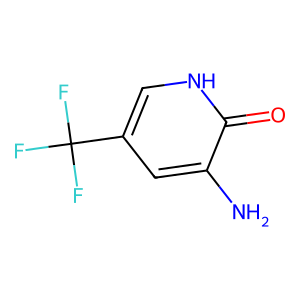

In [25]:
initial_mol = dm.to_mol(initial)
display(dm.to_image(initial_mol))

In [26]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

In [27]:
safe_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=500)

safe_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

['Cc1ccn(C)c1C(=O)N1CCC[C@H](N(C)C(=O)[C@@H]2C[C@H]2C2CCC2)CC1',
 'Cc1noc(C(C)(C)NC(=O)Nc2ccc(-c3csc(C)n3)cc2)n1',
 'CCN(CC)CCCC(=O)c1nc2ccccc2n1C',
 'CCCOc1cccnc1C(=O)O[C@@H](C(=O)Nc1cccc(C)c1)C(C)C',
 'C[C@@](CO)(NC(=O)c1nc(Cl)c2ccccc2c1Cl)c1cccc(O)c1',
 'CC(C)[C@@H](O)C(=O)N1CC[C@H](CN(C)c2nccnc2C#N)C1',
 'CCOC(=O)c1cnc(OC)nc1-c1cc(F)c(C)c(F)c1OC',
 'COc1cc(CCC(=O)N[C@H]2C[C@@H](O)C2)ccc1Cl',
 'C[C@H](NC(=O)N[C@H]1CCN(C(=O)[O-])C1)c1cscn1',
 'Cc1nc(NC[C@@](C)(O)c2cccc(C(F)(F)F)c2)cc2nncn12',
 'CC[C@@H](C)c1nnc(N2CC[C@](F)(C#N)C2)n1Cc1cc(-c2ccccc2)no1',
 'Cc1ccc(-n2cccn2)cc1NC(=O)NCCCc1nc(-c2ccc(F)cc2)no1',
 'CCOC(=O)[C@H](C)NC(=S)N1C[C@@H](C2CCCCC2)C[C@H]1C(=O)[O-]',
 'CN(C(=O)C1CC2(CC2)C1)[C@H]1CCSc2ccc(Br)cc21',
 'C[C@@H]1C[C@H]2CCCC[C@H]2N1C(=O)[C@@H]1CC[C@@H]2CCC(=O)N2C1',
 'C[C@H](c1ccccc1)N(C)C(=O)CN(C)C(=O)c1ccc(CS(C)(=O)=O)cc1',
 'CC[C@H](C)c1cc(C(=O)N2CC[C@@H](CN(C)C(=O)c3ccc(C)o3)C2)on1',
 'COCC[NH+]1CCC(n2cc(CNC3CC3)nn2)CC1',
 'CN(CCC1CCCCC1)C(=O)C[C@H]1CCS(=O)(=O)C1',
 '

In [28]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = safe_smiles
temp_df['Input_SMILES'] = initial

In [29]:
len(temp_df)

464

In [30]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in safe_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'safe'

len(temp_df)

381

In [31]:
df = pd.concat((df, temp_df))

In [32]:
df

,SMILES,Input_SMILES,Tanimoto,Model
648,CNc1cc(C)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.260000,reinvent
711,Nc1cc(C(F)(F)F)c(=O)[nH]c1C(F)(F)F,Nc1cc(C(F)(F)F)c[nH]c1=O,0.326531,reinvent
111,NSc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(C(F)(F)F)c[nH]c1=O,0.722222,reinvent
271,C[C@@H]1CN(c2cc(C(F)(F)F)c[nH]c2=O)C(=O)N1,Nc1cc(C(F)(F)F)c[nH]c1=O,0.375000,reinvent
669,CC(C)(C)c1cc(C(=O)O)c(=O)[nH]c1C(C)(C)C,Nc1cc(C(F)(F)F)c[nH]c1=O,0.132075,reinvent
...,...,...,...,...
457,CCCCC1CCC(CNC(=O)N[C@@H]2CCO[C@H]2c2cnn(C)c2)CC1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.049505,safe
458,O=C(Nc1ccc(Sc2ccncc2)cc1)c1ccc(F)c(Cl)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.086957,safe
460,Cc1nn(C[NH+]2CCN(C(=O)[NH+](C)C3CCCCC3)CC2)c(=...,Nc1cc(c[nH]c1=O)C(F)(F)F,0.042105,safe
461,Cc1cc(C)cc(C(=O)Nc2ccccc2C(O)=NC(C)(C)C)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.090909,safe


## Visualizing the models in chemical space

### PCA

In [33]:
smiles = df['SMILES'].values
mols = [MolFromSmiles(smile) for smile in smiles]

In [34]:
fpgen = AllChem.GetMorganGenerator()

fingerprints = [fpgen.GetFingerprint(mol).ToList() for mol in mols]

In [35]:
df['Fingerprints'] = fingerprints

In [36]:
X = fingerprints

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [37]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X)

In [38]:
var1, var2, var3 = pca.explained_variance_ratio_

array([0.01127421, 0.00535611, 0.00460931])

In [39]:
df['PC1'], df['PC2'], df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [40]:
plot_df = df.sample(n=500)

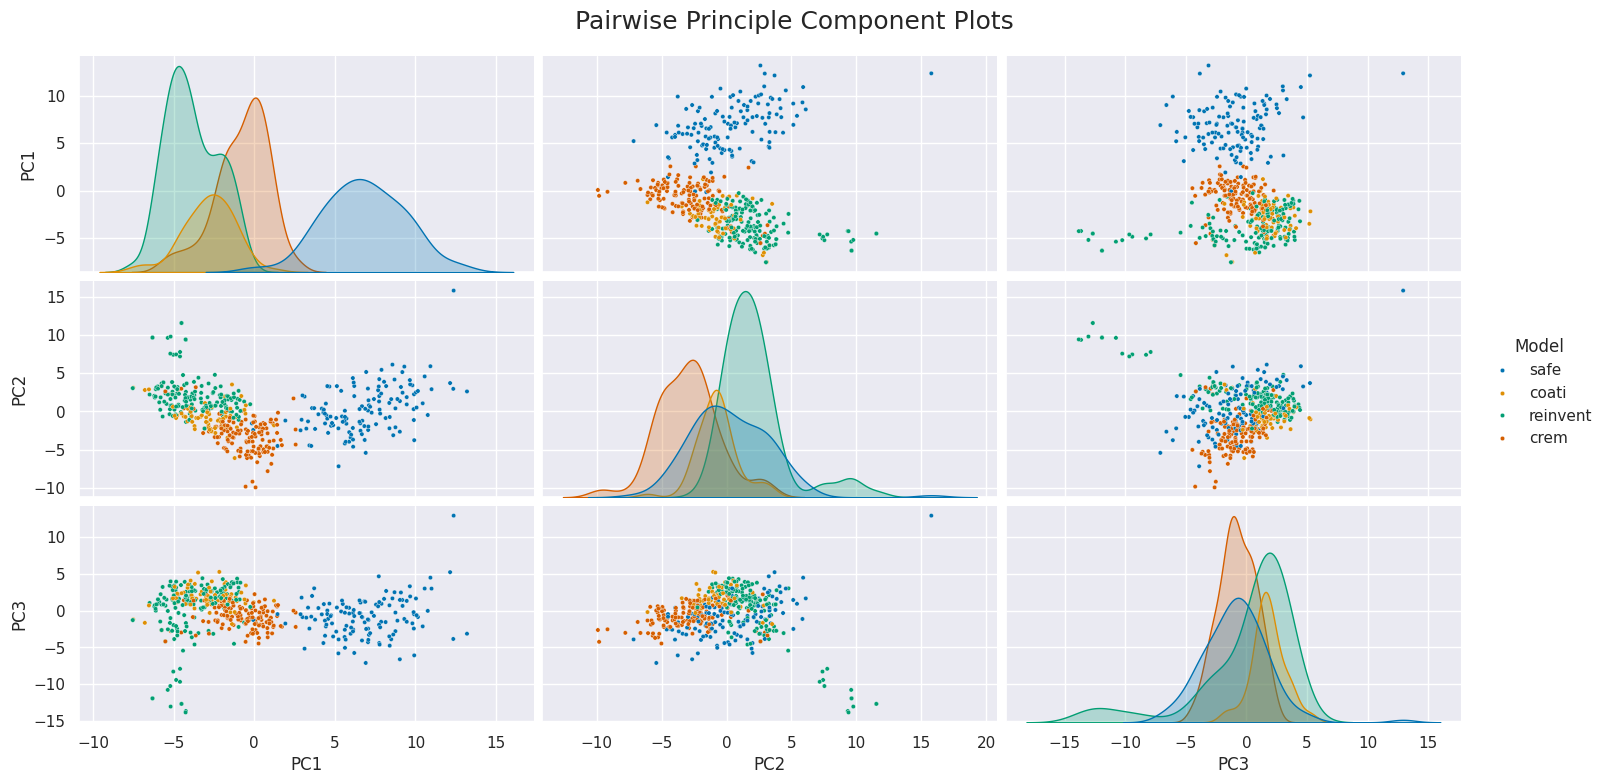

In [41]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['PC1', 'PC2', 'PC3'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle('Pairwise Principle Component Plots', fontsize=18, y=1.04);

### t-SNE

In [82]:
p = 50

pca_model = PCA(n_components=5, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [83]:
df['TSNE1'], df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

In [84]:
plot_df = df.sample(n=500)

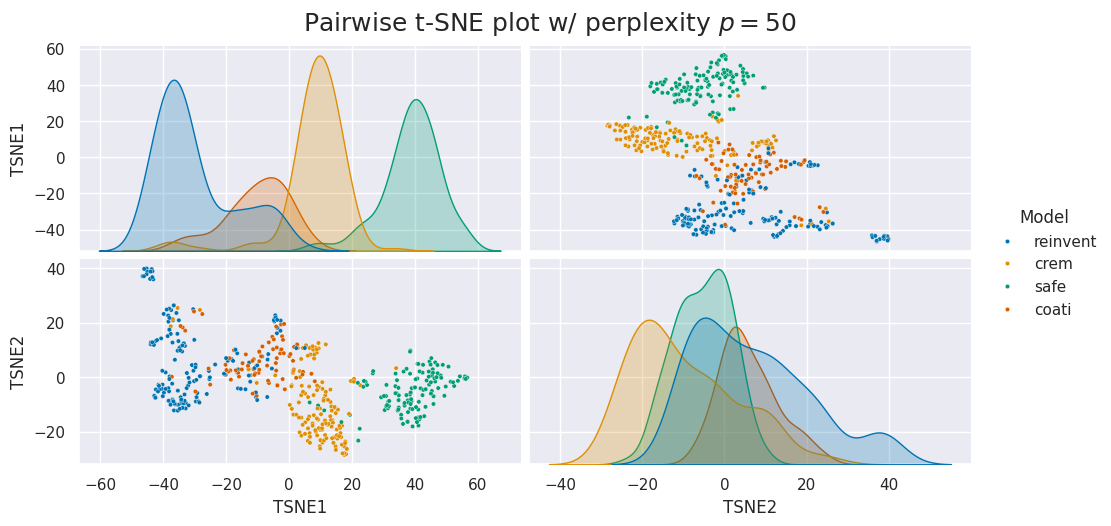

In [85]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);